# XY-calibration (QSO)

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from functools import reduce
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 1.0063 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0272 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09258 ''/inc and Ce is 0.01027 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F4"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F4_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-0-F4_230820_good.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)
#changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
# ra, dec, rot = 36.9049,	0.65245,	0
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)
		
	
# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)


# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"

F1_stars = Table.read(star_target_path).to_pandas()

stars =  [29, 34, 18, 14 ]
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))




FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    (0.18585616, 0.01856568)>
FOV center pixel position in guider [array(1377.264363), array(605.11696717)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (36.9049, 0.65245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39242605  36.4130725262  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024526131524219  0.00024414585789761  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV cente

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_21345/1111387855.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_21345/1111387855.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_21345/1111387855.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
# f_ra, f_dec, f_rot = 14.62883, 0.00512, 90-100
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

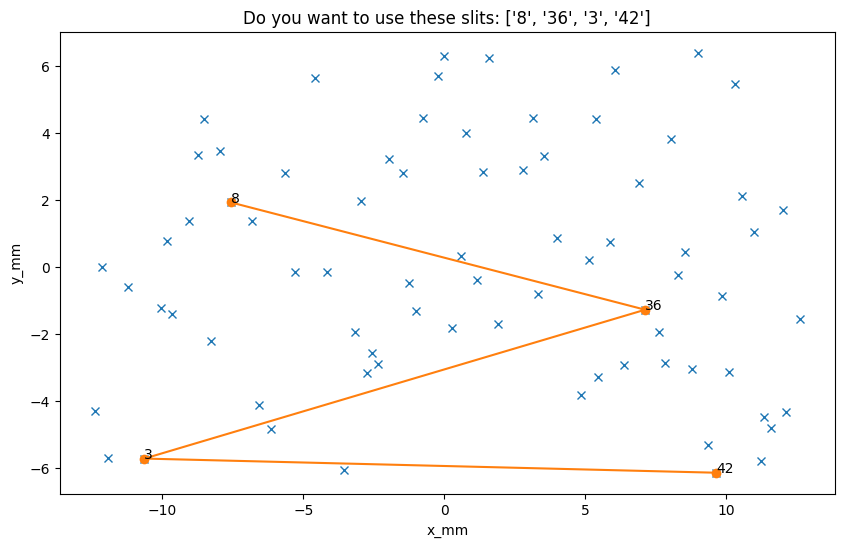

In [7]:
slits =['23', '36', '2', '13', '32', '11',"42"]
slits =['8', '36', '3','42']
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [-7.570966  1.9379  ]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-10.639824  -5.707051]
slit position in mm on mask: [ 9.655641 -6.129349]

targets local coords in siderostat local frame:
EL: 414.5 arcsec ; CE: -346.5 arcsec
EL: 278.9 arcsec ; CE: 263.4 arcsec
EL: 90.9 arcsec ; CE: -473.7 arcsec
EL: 73.0 arcsec ; CE: 367.8 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=73.0191 and CE=367.8310


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [10]:

slits_coord_obs_det = np.array([
[ 1760,	1700 ],
[ 1547,	568 ],
[ 1254,	1932 ],
[ 1227,	371  ],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.22557003, 0.23006721)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.15161804, -0.1147992)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.04706753, 0.30140591)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39242605, 36.41307253)>): (lon, lat) in deg
     [(0.03962924, -0.1728183)]>]

### look at siderostat frame hysteresis 

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: -12.7 arcmin
dx: 13.5 arcsec
dy: -120.8 arcsec
variances: [2.13135577 0.50360718 0.56702582]

residuals in arcsec: [[-5.98616549 -7.43300146]
 [-4.01975057  4.90341207]
 [ 3.60039277 -9.62495887]
 [ 6.40552329 12.15454826]]
max residual in EL,CE 6.4, 12.2 arcsec
mean residual in EL,CE 5.1, 8.9 arcsec
After updating:
    mask_rotation: -12.706511290279055 arcmin
    FOV center in guider: 1391.8438154342637 x 467.91239206527615 pix = 682.820863711298 arcsec x -56.464924621507684 arcsec arcsec
    mask_magnification correction: 1.0  
    
[-3.13488755 -0.74171202  0.23153353  0.15651083  0.05170811  0.04201715] [44.97727251 22.28114609  0.19638648 -0.14891941  0.26876544 -0.20833038]
[-2.96489604 -0.65560934  0.23600708  0.15970807  0.05644919  0.0449948 ] [44.95529617 22.25032416  0.16196727 -0.18306133  0.2350109  -0.24204911]


/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe/guider2UV/guider2UV.py:296: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


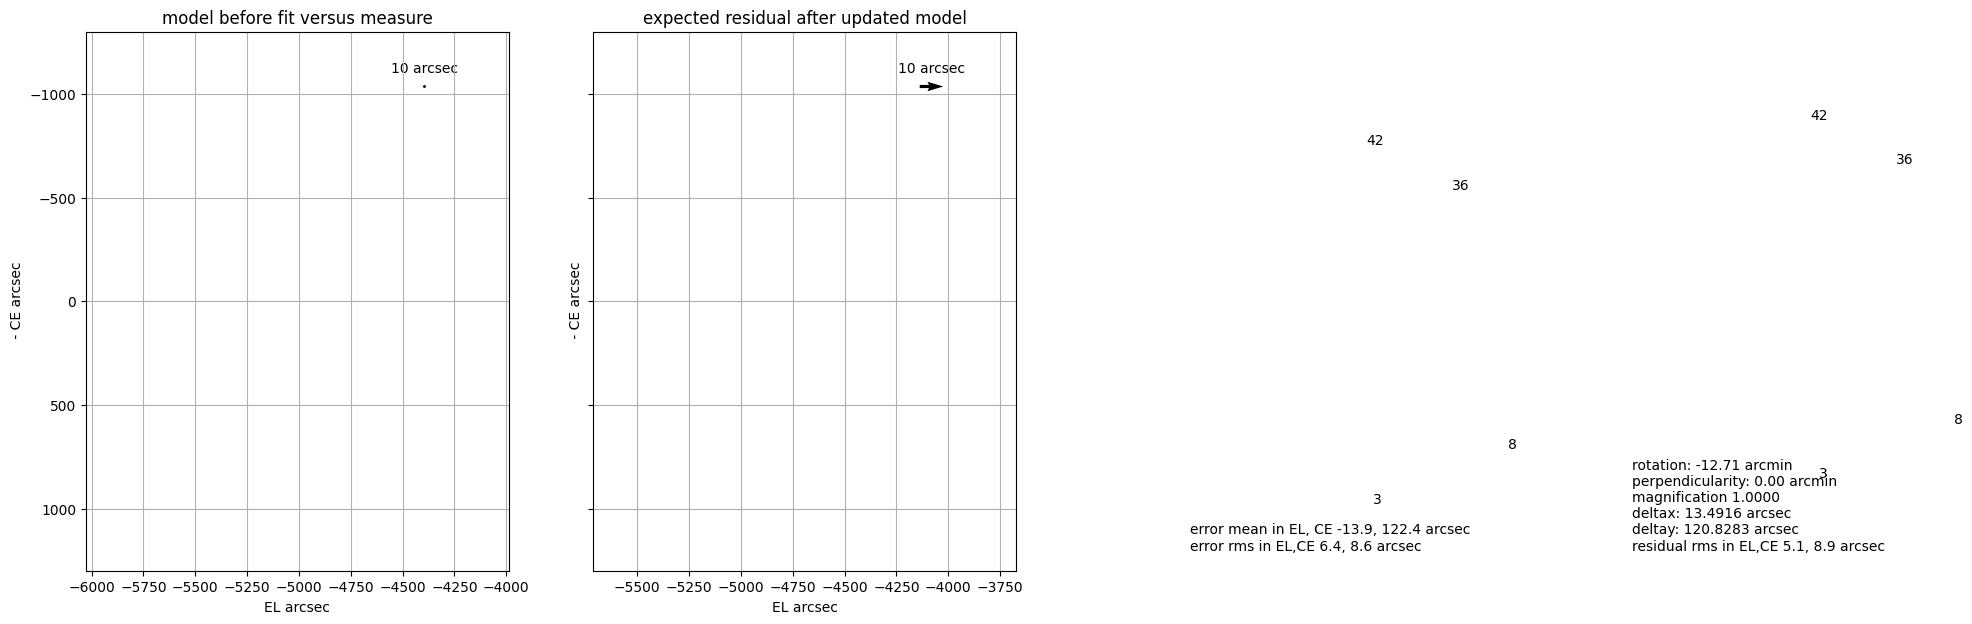


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [11]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits,gamma=False,selected_stars=stars_and_slits)


### check updating without fitting magnification


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (0.103894, 1.59459)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39242605  36.4130725262  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024526131524219  0.00024414585789761  
NAXIS : 0  0

    mask_rotation: -12.706511290279055 arcmin
    FOV center in guider: 1391.8438154342637x467.91239206527615 pix

Fitting rotation, translation and magnification
gamma: 1.012356093016554
theta: -12.706511290279089 arcmin
dx: 8.161873987779618 arcsec
dy: -122.02746094860707 arcsec
variances: [6.19986261e-04 2.13135577e+00 5.

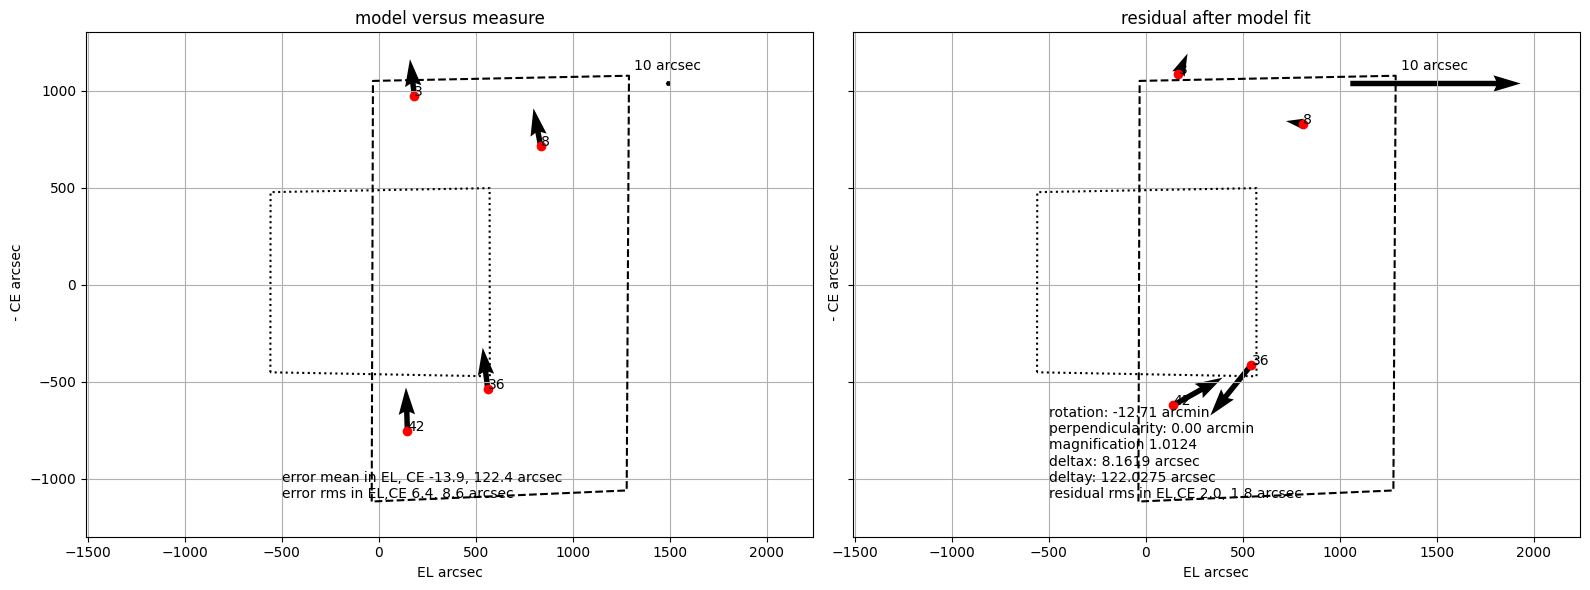


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [12]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False)


### sVerify what magnification it predicts
### save corrected model for future use (eg redo the calib on same field)

# Another try in open mask

In [13]:
slits =['8', '36', '3','45']
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-7.570966  1.9379  ]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-10.639824  -5.707051]
slit position in mm on mask: [12.030937  1.720028]

targets local coords in siderostat local frame:
EL: 422.5 arcsec ; CE: -286.1 arcsec
EL: 284.6 arcsec ; CE: 323.2 arcsec
EL: 99.4 arcsec ; CE: -414.6 arcsec
EL: 410.2 arcsec ; CE: 526.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,422.479956,-286.142853,True,422.479956,-286.142853
1,-137.859022,609.345149,True,284.620934,323.202295
2,-185.237008,-737.764825,True,99.383926,-414.562530
3,310.807929,941.165272,True,410.191854,526.602742


wave:  0.20619
Fitting rotation, translation and magnification
gamma: 1.0149761312168804
theta: -0.5409801195923764 arcmin
dx: -8.37229554749142 arcsec
dy: -2.9543323176994654 arcsec
variances: [5.83967488e-04 2.00753235e+00 6.16277015e-01 6.16277015e-01]

residuals in arcsec: [[ 1.55700584  0.66115999]
 [-1.8265913  -6.51446748]
 [-0.25070553  0.497162  ]
 [ 0.52029099  5.35614549]]
max residual in EL,CE 1.8, 6.5 arcsec
mean residual in EL,CE 1.2, 4.2 arcsec
After updating:
    mask_rotation: -13.247491409871431 arcmin
    FOV center in guider: 1393.8322968469458 x 463.5186070988763 pix = 684.6656974283062 arcsec x -60.37233498574888 arcsec arcsec
    mask_magnification correction: 1.0149761312168804  
    


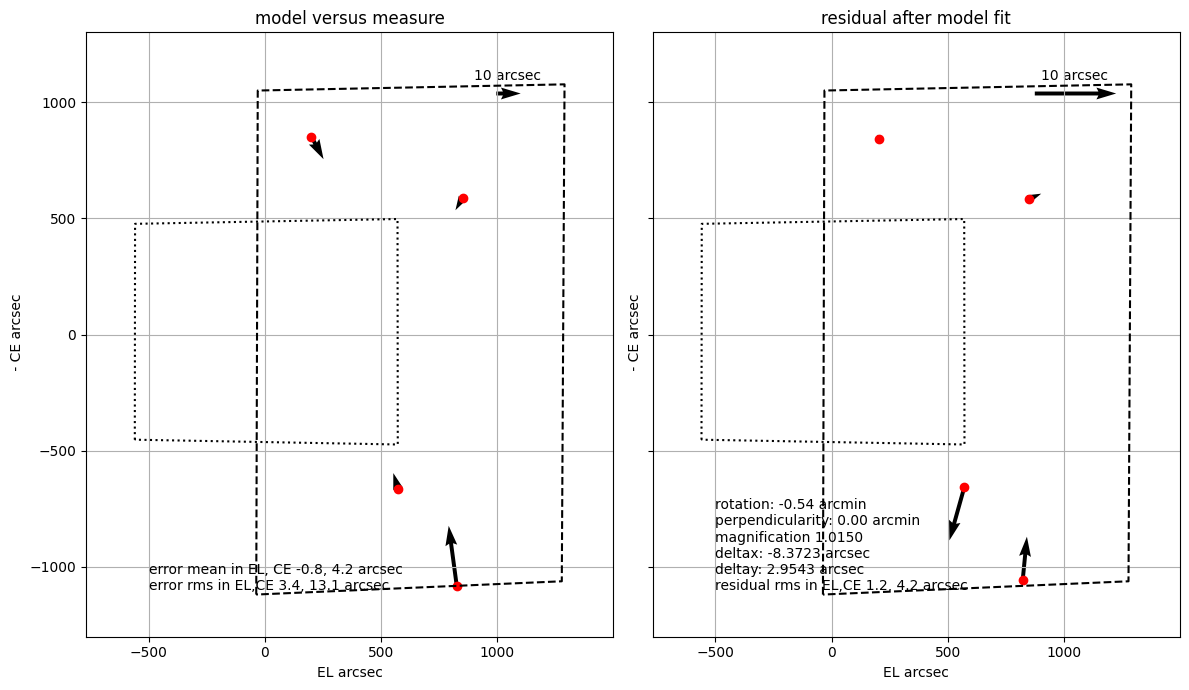


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [15]:
slits_coord_obs_det = np.array([
[ 1774,	1591 ],
[ 1559,	457],
[ 1266,	1823],
[ 1768,	79]])



valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),gamma=True,inplace=False)#, labels=slits)#



In [47]:
slits =[  '7',"3","11","14"]# short pass
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [9.97879885 2.54172577]

targets local coords in siderostat local frame:
EL: 388.2 arcsec ; CE: -423.6 arcsec
EL: 484.1 arcsec ; CE: 340.7 arcsec
EL: 315.7 arcsec ; CE: -157.0 arcsec
EL: 439.2 arcsec ; CE: 474.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,388.186429,-423.634002,True,388.186429,-423.634002
1,95.895126,764.328323,True,484.081555,340.694321
2,-168.353354,-497.700372,True,315.728201,-157.006051
3,123.517319,631.365730,True,439.245521,474.359680


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

slit position in mm on mask: [-12.49939635  -1.77959053]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]

targets local coords in siderostat local frame:
EL: 283.5 arcsec ; CE: -491.9 arcsec
EL: 388.6 arcsec ; CE: -435.2 arcsec
EL: 491.7 arcsec ; CE: 317.8 arcsec
EL: 320.0 arcsec ; CE: -171.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


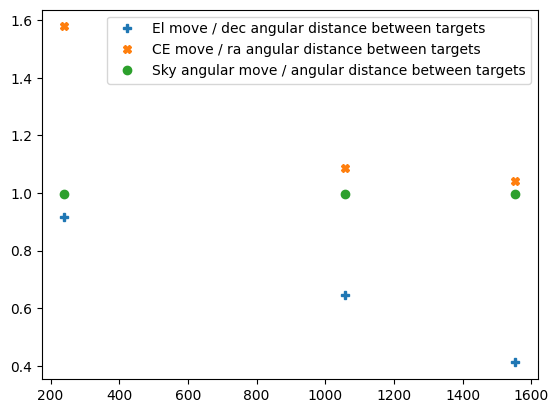

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,-12.499396354705528,-1.7795905324848371,14.34419,-0.08793,-73.15191385601173,-228.81599999999997,240.2248204428455,105.12209493488488,56.70619680228191,209.5924328811735,115.45381668944597,239.28763384096848,0.9960987103657759,-0.9159867879919827,-1.5782747245232573
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-1470.4198669921757,-499.39199999999994,1552.9091908122919,103.13688827943136,752.9973343747637,205.63432785153026,1533.102572787019,1546.8319157158373,0.9960865225523743,-0.411769367253641,-1.042629120567491
3,6.7942147847059475,3.485314424962899,14.772960000000001,0.11435,914.8661779706479,530.028,1057.3125386462705,-171.6811254765802,-489.19237087116215,-342.2978279752056,-995.9956670936862,1053.173856448184,0.9960856586422542,-0.6458108401352487,-1.0886790779641666


In [14]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

wave:  0.20619
Fitting rotation, translation and magnification
gamma: 0.9923329277474556
theta: -43.359455144845754 arcmin
dx: 39.21808344975179 arcsec
dy: -33.34592532683972 arcsec
variances: [8.87470084e-04 3.05089742e+00 9.29935185e-01 9.29935185e-01]

residuals in arcsec: [[-5.93324162  0.08942332]
 [-2.63716849 -1.67222086]
 [ 8.57041011  1.58279754]]
max residual in EL,CE 8.6, 1.7 arcsec
mean residual in EL,CE 6.2, 1.3 arcsec


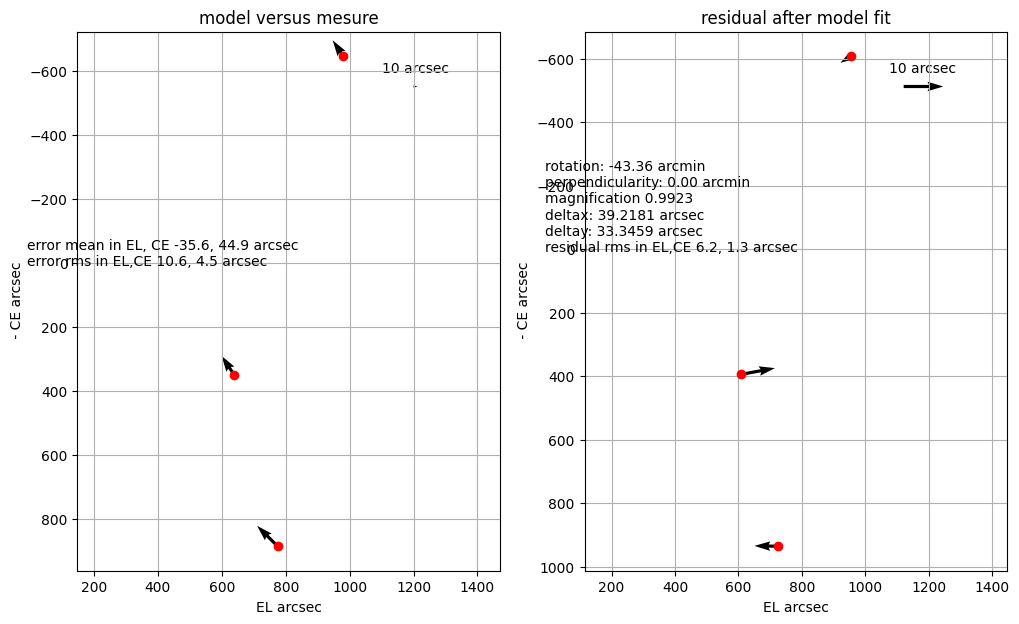

After updating:
    mask_rotation: -0.7226575857474292 deg
    FOV center in guider: 1392.116036233382 x 471.1004256326169 pix = 689.5247433366412 arcsec x -65.14675283925241 arcsec arcsec
    mask_magnification correction: 0.9923329277474556  
    
slit position in mm on mask: [-12.49939635  -1.77959053]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]

targets local coords in siderostat local frame:
EL: 276.9 arcsec ; CE: -489.1 arcsec
EL: 382.0 arcsec ; CE: -433.4 arcsec
EL: 490.1 arcsec ; CE: 316.2 arcsec
EL: 315.6 arcsec ; CE: -170.1 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


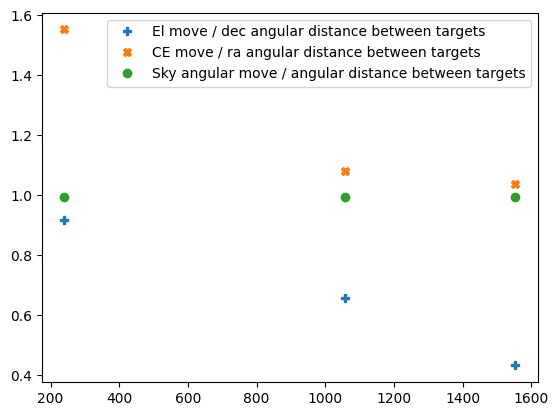

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9,-12.499396354705528,-1.7795905324848371,14.34419,-0.08793,-73.15191385601173,-228.81599999999997,240.2248204428455,105.13157586246355,55.78555654426063,209.61133595457983,113.57939312411465,238.4055173503875,0.9924266647838297,-0.9160694005427061,-1.5526510126266577
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,-1470.4198669921757,-499.39199999999994,1552.9091908122919,108.05937610828465,749.5066465027177,215.44878408469793,1525.995532279533,1541.1296321532043,0.9924145218994255,-0.43142217753728124,-1.0377957796510466
3,6.7942147847059475,3.485314424962899,14.772960000000001,0.11435,914.8661779706479,530.028,1057.3125386462705,-174.49068420469519,-486.2173735729918,-347.89952616732126,-989.9385725946113,1049.2914074832133,0.9924136611740867,-0.6563795236616202,-1.0820583342478445


In [15]:
slits_coord_obs_det = np.array([
[ 435.4,	1964.8],
[ 597.6,	1856.9],
[ 744.2,	459.3],
[ 479.6,	1370.5],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),gamma=False)#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"



In [16]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl")

Dumping to Calibration/Mappings/2022/XY/QSO1_XY_230621_Field3.pkl


# Again another iteration in open mask? NO

In [17]:
# slits_coord_obs_det = np.array([
# [ 670.6,	221.5 ],
# [ 364.6,	1672.1],
# [ 640.9,	704.2 ],
# [ 594.8,	1854  ],
# [ 515.8,	167.7 ],
# # [ 1738.5	,1903.5  ],
# # [ 1592.6	,1205.5  ],
# # [ 1569.6	,1765.5  ],
# # [ 1788.5,	732.5  ]
# ]) 


# valid = np.isfinite(slits_coord_obs_det[:,0])
# obs_wave =  0.20619
# print("wave: ", obs_wave)
# slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# # slits_valid = slits[valid]
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# slits_coord_obs
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
# G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


# moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
# moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# try:
#     moves.to_pandas().to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves

# new_cat = slit_path[:-1]
# new_cat["EL"] = moves["EL"][1:]
# new_cat["CE"] = moves["CE"][1:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()



# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"




## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence We begin by QSO 5
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [18]:
# il faut que le centre soit bien defini à l'arcseconde pres.
# stars = [2, 4, 5, 6, 7]
stars =  [13,14]#[2, 4, 5, 6, 7]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves





targets local coords in siderostat local frame:
EL: 28.7 arcsec ; CE: 244.5 arcsec
EL: -119.4 arcsec ; CE: -30.4 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,28.707642,244.489588,1.0
1,-148.143452,-274.909050,1.0


In [19]:
stars_path = vstack((selected_stars,selected_stars[::-1]) )
selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
print("(They have been copied to clipboard, paste it in the spreadsheet)")
star_moves.to_clipboard()


(They have been copied to clipboard, paste it in the spreadsheet)


In [20]:


stars = [8, 10, 12] #QSO7
#back to guider center
#Load new 
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(22.42638*u.deg, 0.62279*u.deg), rotation=(90-70)*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363



Dumping to Calibration/Mappings/2022/XY/QSO1_XY_230621_Field2.pkl


In [21]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()




targets local coords in siderostat local frame:
EL: -89.1 arcsec ; CE: 83.5 arcsec
EL: -50.8 arcsec ; CE: 251.0 arcsec
EL: 291.2 arcsec ; CE: 105.4 arcsec

siderostat moves sequence: 


In [22]:



stars = [17, 18, 19, 20, 21] #QSOV 14
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(351.8533*u.deg, -1.8553*u.deg), rotation=0*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves


Dumping to Calibration/Mappings/2022/XY/QSO1_XY_230621_Field4.pkl

targets local coords in siderostat local frame:
EL: 105.2 arcsec ; CE: -208.1 arcsec
EL: 285.8 arcsec ; CE: 140.5 arcsec
EL: 326.0 arcsec ; CE: 144.9 arcsec
EL: 169.1 arcsec ; CE: 190.7 arcsec
EL: 74.0 arcsec ; CE: 195.9 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,105.169895,-208.128438,1.0
1,180.597134,348.643380,1.0
2,40.262927,4.420816,1.0
3,-156.920299,45.789053,1.0
4,-95.128796,5.166559,1.0


In [23]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 105.2 arcsec ; CE: -208.1 arcsec
EL: 285.8 arcsec ; CE: 140.5 arcsec
EL: 326.0 arcsec ; CE: 144.9 arcsec
EL: 169.1 arcsec ; CE: 190.7 arcsec
EL: 74.0 arcsec ; CE: 195.9 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [24]:
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.03894*u.deg, 1.39459*u.deg), rotation=(90-100)*u.deg, gamma=1)
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()


Dumping to Calibration/Mappings/2022/XY/QSO1_XY_230621_Field1.pkl

targets local coords in siderostat local frame:
EL: 6.1 arcsec ; CE: 15.2 arcsec
EL: 84.8 arcsec ; CE: -92.3 arcsec
EL: 96.4 arcsec ; CE: -79.4 arcsec
EL: 238.9 arcsec ; CE: -10.0 arcsec
EL: 159.3 arcsec ; CE: -3.3 arcsec

siderostat moves sequence: 


In [36]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 6.1 arcsec ; CE: 15.2 arcsec
EL: 84.8 arcsec ; CE: -92.3 arcsec
EL: 96.4 arcsec ; CE: -79.4 arcsec
EL: 238.9 arcsec ; CE: -10.0 arcsec
EL: 159.3 arcsec ; CE: -3.3 arcsec

siderostat moves sequence: 


In [22]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------